In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
from torch.utils.data import Dataset, DataLoader
import random
from collections import namedtuple, deque
import time

import gymnasium as gym


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
torch.cuda.is_available()

False

# Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F




In [6]:
class net(nn.Module):
    

    def __init__(self):
        super(net, self).__init__()
        self.layer1 = nn.Linear(4, 128) # 4 is length of states vector, 2 is number of actions
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, 2)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
    def act(self, state): # I assume batch contains only 1 vector, otherwise it should be changed
        y = self(state) # vector of length 2
        return torch.argmax(y).item()

    
class random_model:

    def __init__(self):
        self.x = 1
    
    def act(self, state):
        return np.random.randint(0,2)
        

        
    

# Train

In [7]:
import torch.optim as optim 

In [8]:
class Memory(Dataset):
    
    def __init__(self, l):
        self.l = l
        
    def __len__(self):
        return len(self.l)
    
    def __getitem__(self, idx):
        prev_state = torch.tensor(self.l[idx][0],dtype = torch.float32)
        action = torch.tensor(self.l[idx][1])
        reward = torch.tensor(self.l[idx][2], dtype = torch.float32)
        done = torch.tensor(self.l[idx][3])
        next_state = torch.tensor(self.l[idx][4],dtype = torch.float32)
        
        return (prev_state,action,reward,done,next_state)
    
    

In [9]:
def select_action(policy, game, state, eps):
    
    if np.random.rand() < eps:
        return game.action_space.sample() 
    else:
        with torch.no_grad():
            return policy.act(torch.tensor(state))

In [10]:
def train(model, game, data_size, optimizer, n_epoch = 10000, batch_size = 32, eps = 0.01, gamma = 1.0, target_update = 100):
    
    # prepare dataset on which we train, dataset is called memory
    
    memory = []
    
    obs_0, info = game.reset()
    while len(memory) < data_size:
        a = select_action(model, game, obs_0, eps)
        obs_1, r, terminated, truncated, info = game.step(a)
        done = terminated or truncated
        sample = (obs_0, a, r, done, obs_1)
        memory.append(sample)
        if terminated or truncated:
            obs_0, info = game.reset()
    
    memory = Memory(memory)
    memory_dataloader = DataLoader(memory, batch_size = batch_size, shuffle = True)
    
    
    # memory is ready, now we train on memory
        
    target_nn = net().to(device)
    model.to(device)
    target_nn.load_state_dict(model.state_dict())
    step = 1 # for target update
    
    # add loss per epoch
    huber_loss = nn.SmoothL1Loss()
    t = time.time()
    
    losses_per_epoch = []
    
    for epoch in range(n_epoch):
        total_loss = 0.0
        for batch, data in enumerate(memory_dataloader):
            #t_per_batch = time.time()
            prev_states, actions, rewards, dones, next_states = data
            
            prev_states = prev_states.to(device)
            #print(prev_states.is_cuda)
            
            actions = actions.to(device)
            
            rewards = rewards.to(device)
            dones = dones.to(device)
            next_states = next_states.to(device)
            #print(model.is_cuda)
    
            predicted = model(prev_states)[torch.arange(len(prev_states)).to(device),actions]
            
            target = target_nn(next_states).max(dim = 1).values * dones + rewards # if done is true target value should be 0
           # print(predicted.size())
           # print(target.size())
            
            loss = huber_loss(predicted, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss
          #  if step % 100 == 0:
           #     loss, current = loss.item(), (batch + 1) * batch_size
          #      print(f"loss is {loss} step {step}")
                
            if step%target_update == 0:
                # copy target
                target_nn.load_state_dict(model.state_dict())
           #     print("updated target network")
            step += 1
            #t_per_batch_new = time.time()
            #print(f"time to train batch is {t_per_batch_new - t_per_batch}")
            #t_per_batch_new = time.time()
        if epoch % 10 == 0:
            
            print(f"at epoch {epoch} total loss is {total_loss}")
            t_new = time.time()
          #  print(f"time for epoch {epoch} is {t_new - t}")
            t = t_new
            
        losses_per_epoch.append(total_loss)
    return losses_per_epoch
                  
                
    

In [11]:
device

device(type='cpu')

In [12]:
env = gym.make('CartPole-v1')
linear = net()
print(linear)


#sgd = optim.SGD(linear.parameters(), lr = 1e-3)
adam = optim.AdamW(linear.parameters(), lr=1e-4, amsgrad=True)

net(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)


In [13]:
losses = train(linear,env,10000,adam, batch_size = 64,n_epoch = 10, target_update = 30)

at epoch 0 total loss is 36.3692512512207


In [14]:
print(device)

cpu


In [15]:
#losses = [l.item() for l in losses]
#plt.plot(losses)

In [16]:
def play(model, episodes, text = False, show = False, plot = False):

    if show:
        game = gym.make('CartPole-v1', render_mode = "human")
    else:
        game = gym.make('CartPole-v1')
    rewards = []
    for ep in range(episodes):
        obs, info = game.reset()
        obs = torch.from_numpy(obs)
        t_r = 0.0
        duration = 0
        while True:
            time.sleep(0.01)
           # action = model(obs).argmax().item()
            action = model.act(obs)
            obs, reward, terminated, truncated, info = game.step(action)
            obs = torch.from_numpy(obs)
            if terminated or truncated:
                if text:
                    print(f"duration of episode {ep} was {duration}")
                    print(f"total reward for episode {ep} was {t_r}")
                obs, info = game.reset()
                break
            duration += 1
            t_r += reward
        rewards.append(t_r)
    plt.plot(rewards)





duration of episode 0 was 7
total reward for episode 0 was 7.0
duration of episode 1 was 8
total reward for episode 1 was 8.0
duration of episode 2 was 9
total reward for episode 2 was 9.0
duration of episode 3 was 8
total reward for episode 3 was 8.0
duration of episode 4 was 9
total reward for episode 4 was 9.0
duration of episode 5 was 10
total reward for episode 5 was 10.0
duration of episode 6 was 9
total reward for episode 6 was 9.0
duration of episode 7 was 8
total reward for episode 7 was 8.0
duration of episode 8 was 7
total reward for episode 8 was 7.0
duration of episode 9 was 8
total reward for episode 9 was 8.0
duration of episode 10 was 10
total reward for episode 10 was 10.0
duration of episode 11 was 9
total reward for episode 11 was 9.0
duration of episode 12 was 7
total reward for episode 12 was 7.0
duration of episode 13 was 10
total reward for episode 13 was 10.0
duration of episode 14 was 8
total reward for episode 14 was 8.0


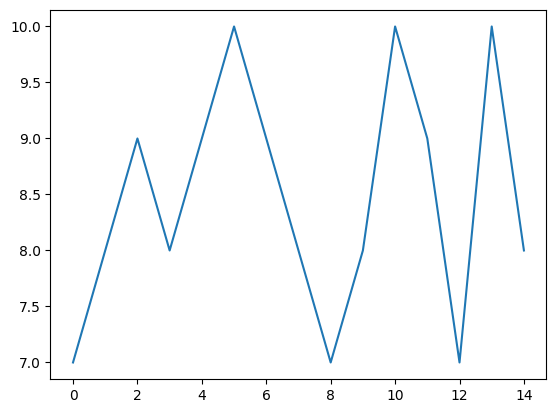

In [17]:
torch.manual_seed(12345)

play(linear.to('cpu'), 15, True, False,True)

duration of episode 0 was 30
total reward for episode 0 was 30.0
duration of episode 1 was 18
total reward for episode 1 was 18.0
duration of episode 2 was 16
total reward for episode 2 was 16.0
duration of episode 3 was 56
total reward for episode 3 was 56.0
duration of episode 4 was 17
total reward for episode 4 was 17.0
duration of episode 5 was 16
total reward for episode 5 was 16.0
duration of episode 6 was 20
total reward for episode 6 was 20.0
duration of episode 7 was 14
total reward for episode 7 was 14.0
duration of episode 8 was 14
total reward for episode 8 was 14.0
duration of episode 9 was 8
total reward for episode 9 was 8.0


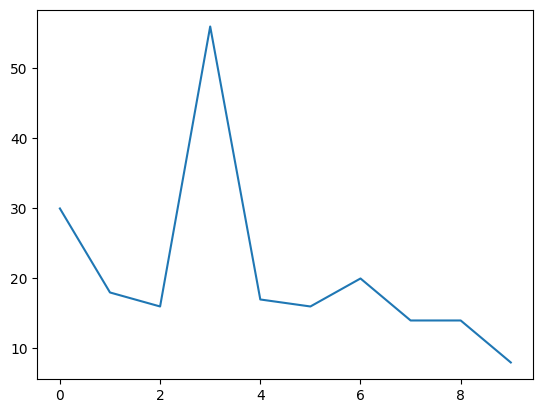

In [18]:
r_m = random_model()
torch.manual_seed(12345)

play(r_m,10,True, False,True)